# __Clasificación de correos de spam con modelo de Decision Tree__


El presente notebook presenta la implementación de 4 modelos distintos de Machine Learning con sklearn para solucionar el problema de clasificación de correos de spam. Los modelos implementados son los siguientes:

- Decision Tree
- Random Forest
- Neural Networks
- Deep learning

Para elllo, se utilizó el el conjunto de datos del repositorio de machine learning de la UC Irvine alojado en: https://archive.ics.uci.edu/dataset/94/spambase.

### __Descripción del Dataset__

El conjunto de datos a trabajar esta enfocado en determinar si un email es spam o no, para lo cual, los autores del dataset definieron una serie de caracteristicas del email consideradaos significativos a la hora de hacer esta clasificación, como lo es el porcentaje de aparicion de ciertas palabras y caracteres especiales, o la longitud de palabras en mayusculas.

Cabe destacar que los emails utilizados para la construccion del dataset fueron extraidos de entornos laborales y personales, por lo que caracteristicas como el porcentaje de aparicion del nombre "george" o del numero de area "650" son fuertes indicadores de que un correo no es spam, por esta razón, estas serán menospreciadas, pues se desea construir un clasificador de proposito general en lugar de uno personalizado.


### __Atributos del Dataset__

El dataset presenta atributos con los siguientes formatos:
- 56 atributos continuas que representan el __porcentaje (%) de aparición de una palabra o caracter__ definido dentro del email.
    - __Formato__:
        -  word_freq_WORD (palabras) 
        -  char_freq_CHAR (caracteres especiales)
    - __Definición__: 
        - WORD representa la palabra en cuestion 
        - CHAR representa caracter en cuestión 
    - __Ejemplo__: 
        - word_freq_make indica el procentaje de apariciones de la palabra "make"
        - char_freq_$ indica el procentaje de apariciones del caracter "$" 
        
    En total se encuentran 48 atributos enfocados a apariciones de palabras y 6 a caracteres especiales.

- 3 atributos continuos que describen el __comportamiento de las palabras en mayusculas ininterrumpidas__ dentro el email. 
    - __Formato__:
        - capital_run_lenght_FEATURE 
    - __Definición__:
        - FEATURE representa la medida que describe el atributo 
            - __Average__: Para la longitud media de las palabras en mayusculas
            - __Longest__: Para la cantidad de letras que tiene la palabra en mayuscula mas larga 
            - __Total__: Para la cantidad total de palabras en mayusculas. 

- 1 atributo de nombre Class que indica __si el correo es spam o no__, mediante los valores de 1 y 0 respectivamente.

### __Librerias Requeridas__

In [183]:
%pip install pandas numpy matplotlib seaborn ucimlrepo scikit-learn mlxtend  

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [184]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### __Importación de Datos del Repositorio__

In [185]:
spambase = fetch_ucirepo(id=94) 
data = spambase.data.original

data.info()
if any(data.isnull().sum()>0): print("Missing values") 
else: print("No missing values")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

### __Análisis de los Datos__

In [186]:
data.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Class
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


Inicialmente, se evalua el balanceo de la cantidad de registros de los valores que puede tomar nuestra variable objetivo dentro del dataset

No spam registers: 2788
Spam registers: 1813


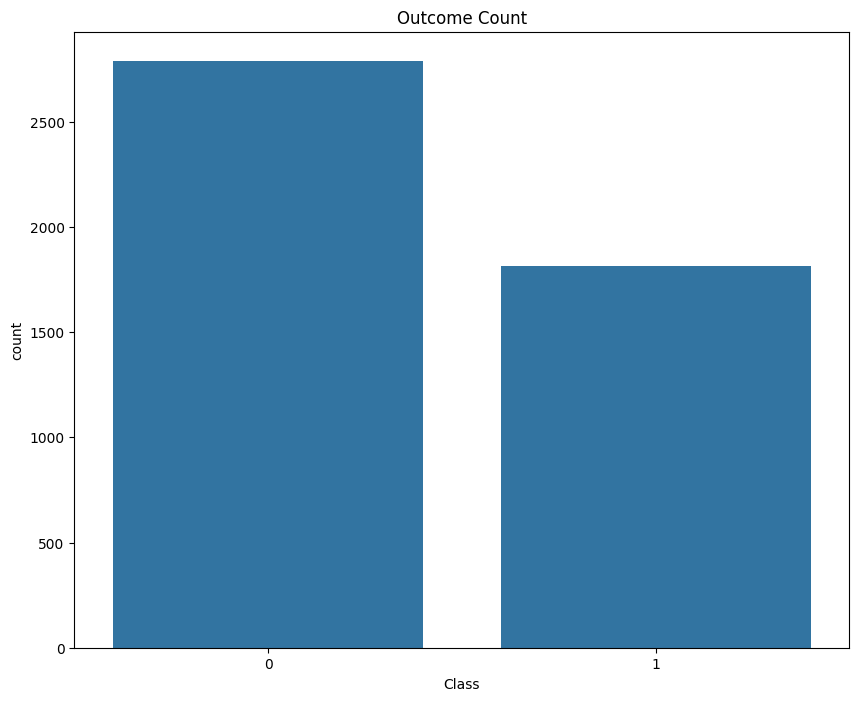

In [187]:
print(f'No spam registers: {len(data[data['Class'] == 0])}')
print(f'Spam registers: {len(data[data['Class'] == 1])}')
#Histograma del atributo clase
ax=plt.subplots(1,1,figsize=(10,8))
sns.countplot(x='Class',data=data)
plt.title("Outcome Count")
plt.show()

El histograma anterior permite evidenciar el __desbalanceo dentro del dataset__, contando con cerca de 975 registros de diferencia, esta es una cifra importante si tenemos en cuenta que la cantidad de correos spam no llega a los 2000. Debido a esto, se opta por __balancear los datos mediante la estrategia de undersampling__.

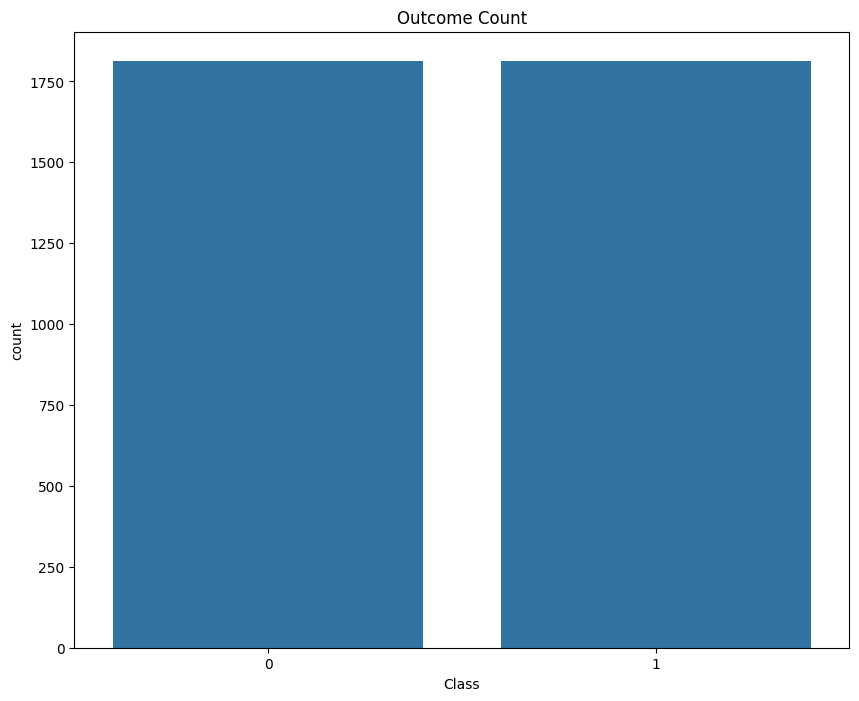

In [188]:

spam_data, no_spam_data = data[data['Class'] == 1], data[data['Class'] == 0]
desired_size = len(spam_data)

no_spam_data_resampled = resample(no_spam_data, replace=False, n_samples=desired_size, random_state=69) 
resampled_data = pd.concat([no_spam_data_resampled, spam_data])

#Histograma del atributo clase
ax=plt.subplots(1,1,figsize=(10,8))
sns.countplot(x='Class',data=resampled_data)
plt.title("Outcome Count")
plt.show()

Esta sección permite __observar el comportamiento de los datos__ para las 57 variables predictoras del dataset

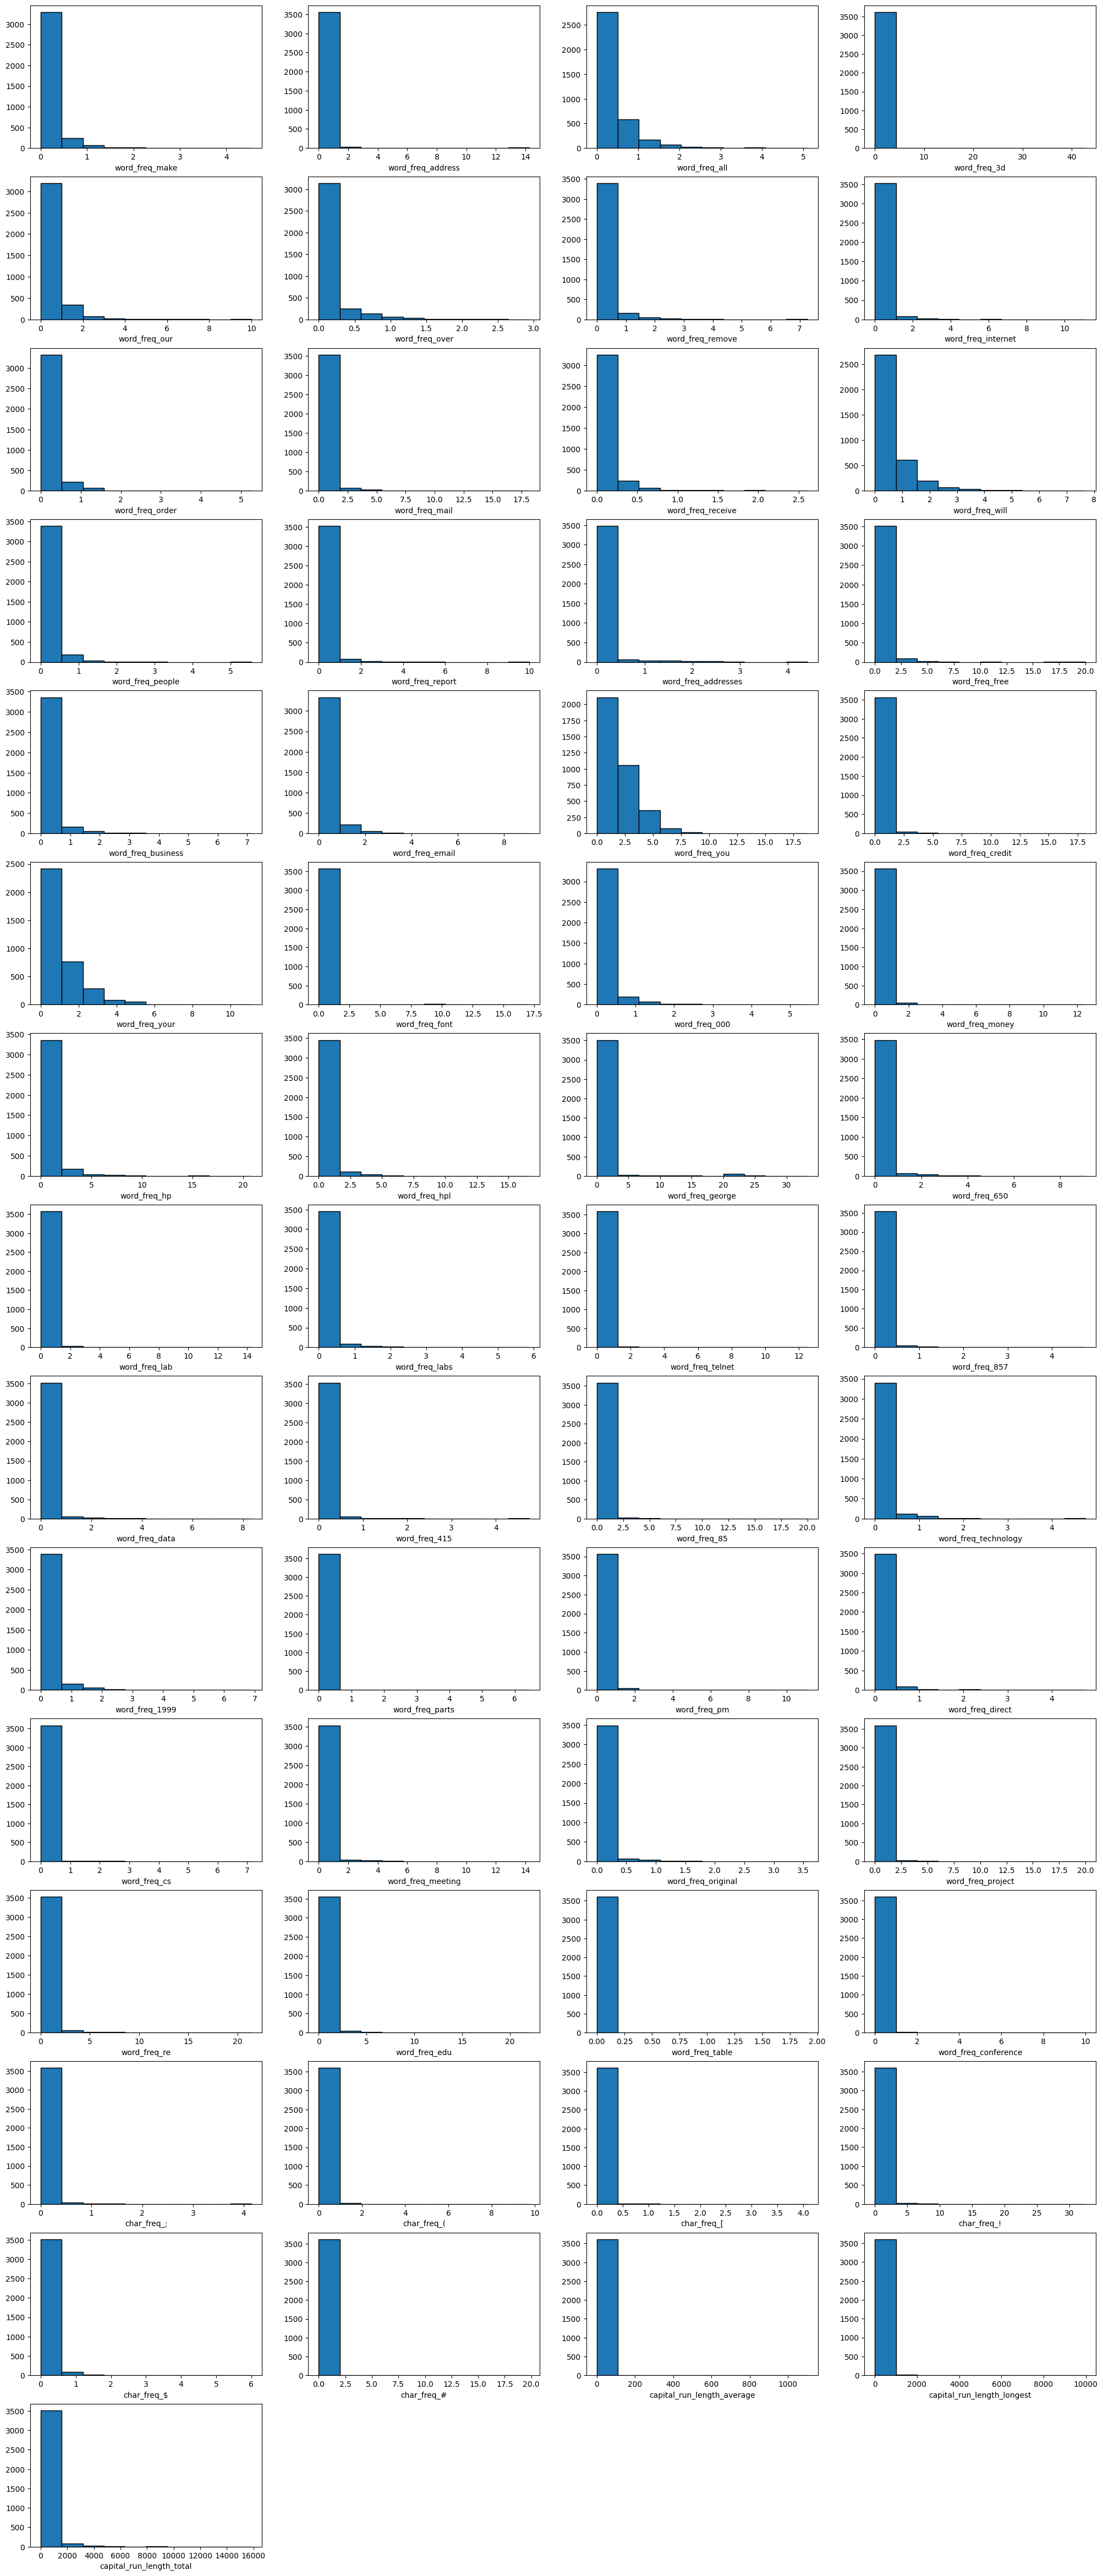

In [189]:
rows, cols = 15,4
fig, axes = plt.subplots(nrows=rows,ncols=cols ,figsize=(25,60))   

current_col = 0
for i in range(rows):
    for j in range(cols):
        if current_col < len(resampled_data.columns)-1:
            axes[i][j].hist(x=resampled_data[resampled_data.columns[current_col]], edgecolor='black', linewidth=1)
            axes[i][j].set_xlabel(resampled_data.columns[current_col])
            current_col +=1
        else:
            axes[i, j].axis('off')


plt.show()


En esta sección se realiza un __analisis de correlación__ entre las variables del dataset mediante un mapa de calor y una matriz de correlación

word_freq_857  word_freq_415    0.9476
word_freq_415  word_freq_857    0.9476
dtype: float64


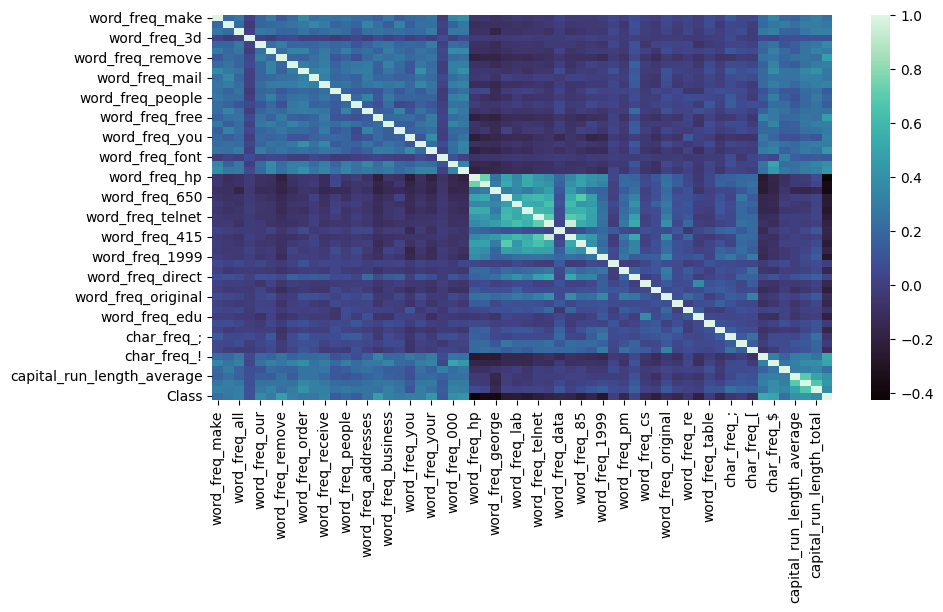

In [190]:
#matriz de correlación
cor_matrix = resampled_data.corr(method="kendall").round(4)
cor = cor_matrix.where(cor_matrix > 0.9).stack().dropna()
cor = cor[cor.index.get_level_values(0) != cor.index.get_level_values(1) ]
print(cor)
plt.figure(figsize=(10,5))
sns.heatmap(data=cor_matrix, cmap="mako")
plt.show()

Los resultados obtenidos permiten concluir que existe una fuerte correlación (por encima del umbral de 0.9), unicamente entre dos variables: __word_freq_857 y word_freq_415__, por lo cual, se procede a realizar más observaciones para determinar si realmente existe una correlación fuerte entre estas.

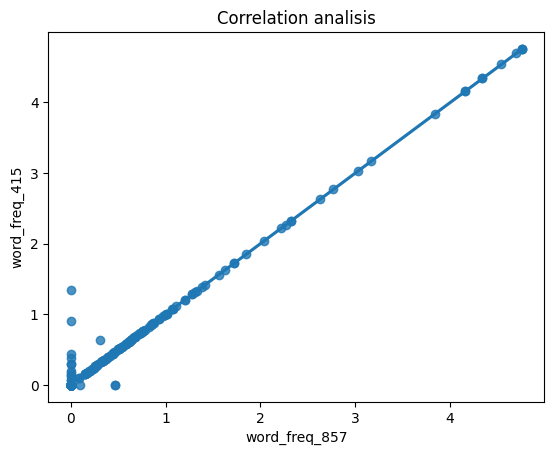

In [191]:
#observando relaciones entre los datos
plt.title('Correlation analisis')
sns.regplot(y='word_freq_415', x='word_freq_857', data=resampled_data);
plt.show()

Los resultados permiten concluir que los atributos en cuestion __presentan una correlacion positiva fuerte__, por lo cual, __al menos una de las dos deberá ser eliminada del dataset__, sin embargo, esta decision será tomada más adelante al analizar el nivel de determinación de las caracteristicas sobre la variable objetivo

### __Selección de caracteristicas__
En esta sección se implementan dos metodos de feature selection: __Filter basado en correlación y Wrapper con RandomForest__. <br>

Con el fin de evidenciar el cambio en el rendimiento de los modelos luego de reducir las caracteristicas, inicialmente se entrenaran tres modelos arbitrarios para luego ser comparados con los resultados obtenidos al entrenar los modelos con los mismos parametros y las caracteristicas reducidas.

In [192]:
#separacion de datos en datos de prueba y de entrenamiento
X_data = resampled_data.drop(['Class'], axis=1)
y_target = resampled_data['Class']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.20)

Este bloque implementa el __metodo filter basado en correlación__. De los resultados obtenidos, unicamente se tomarán como atributos importantes aquellos que superen un umbral de 0.3 de correlación con la variable a predecir.

In [193]:
#Implementación de Filter
corr_matrix = X_train.corrwith(y_train,method='kendall')
corr_matrix = corr_matrix.abs().sort_values(ascending=False)
threshold = 0.3

descriptive_variables = corr_matrix[corr_matrix >= threshold].index.tolist()

print(f'features with less than {threshold} correlation: {len(corr_matrix[corr_matrix < threshold])}')
print(f'features with more than {threshold} de correlation: {len(descriptive_variables)}')

print(descriptive_variables)



features with less than 0.3 correlation: 37
features with more than 0.3 de correlation: 20
['char_freq_!', 'char_freq_$', 'word_freq_remove', 'word_freq_free', 'capital_run_length_longest', 'word_freq_your', 'word_freq_hp', 'word_freq_money', 'capital_run_length_average', 'word_freq_000', 'word_freq_george', 'capital_run_length_total', 'word_freq_hpl', 'word_freq_our', 'word_freq_receive', 'word_freq_business', 'word_freq_you', 'word_freq_credit', 'word_freq_all', 'word_freq_internet']


Este bloque implementa el __metodo wrapper con Random Forest__.

In [194]:
#implementación del wrapper
sfs = SFS(RandomForestClassifier(n_estimators=100, n_jobs = -1), k_features = 12,
          forward= True,
          floating = False,
          verbose= 0,
          scoring= 'accuracy',
          cv = 4,
          n_jobs= -1
         ).fit(X_train, y_train)

#obteniendo las caracteristicas obtenidas
feature_names = list(sfs.k_feature_names_)
print(sfs.k_score_)
feature_names

0.9448275862068966


['word_freq_all',
 'word_freq_our',
 'word_freq_remove',
 'word_freq_free',
 'word_freq_business',
 'word_freq_money',
 'word_freq_hp',
 'word_freq_george',
 'word_freq_edu',
 'char_freq_!',
 'char_freq_$',
 'capital_run_length_longest']

In [195]:
#eliminacion de caracteristicas en los datos
X_train_wrapper = X_train[feature_names]
X_test_wrapper = X_test[feature_names]

X_train_filter = X_train[descriptive_variables]
X_test_filter = X_test[descriptive_variables]


In [196]:
#Definicion de atributos de modelos
#Decision Tree
dtc_criterion = 'entropy'
dtc_splitter = 'best'
dtc_max_depth = 20

#Random Forest
rfc_n_estimators = 200
rfc_max_depth = 12

#Neural Networks
min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.fit_transform(X_test)
nn_hidden_layer_sizes = (10,10,10)
nn_alpha = 0.001
nn_max_iter = 1000

### __Construcción de Modelos en Datos Originales__

In [197]:
#Implementacion de arboles de decision 
dtc_original = DecisionTreeClassifier(criterion=dtc_criterion, splitter=dtc_splitter, max_depth=dtc_max_depth)
dtc_original.fit(X_train,y_train)

#Implementacion de Random Forest
rfc_original = RandomForestClassifier(n_estimators=rfc_n_estimators, max_depth=rfc_max_depth)
rfc_original.fit(X_train, y_train)

#Implementación de Neural Networks 
nn_original = MLPClassifier(hidden_layer_sizes = nn_hidden_layer_sizes, alpha=nn_alpha, max_iter=nn_max_iter)
nn_original.fit(X_train_scaled, y_train)


MLPClassifier(alpha=0.001, hidden_layer_sizes=(10, 10, 10), max_iter=1000)

### __Construccion de Modelos con Atributos reducidos__

In [198]:
#Implementacion de Decision Tree
dtc_w = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=20)
dtc_w.fit(X_train_wrapper, y_train)

dtc_f = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=20) 
dtc_f.fit(X_train_filter, y_train)

#Implementacion de Random Forest
rfc_w = RandomForestClassifier(n_estimators=rfc_n_estimators, max_depth=rfc_max_depth)
rfc_w.fit(X_train_wrapper, y_train)
rfc_f = RandomForestClassifier(n_estimators=rfc_n_estimators, max_depth=rfc_max_depth)
rfc_f.fit(X_train_filter, y_train)

#Implentacion de Neural Network

X_wrapper_scaled = min_max_scaler.fit_transform(X_train_wrapper)
X_wrapper_scaled_test = min_max_scaler.fit_transform(X_test_wrapper)

X_filter_scaled = min_max_scaler.fit_transform(X_train_filter)
X_filter_scaled_test = min_max_scaler.fit_transform(X_test_filter)


nn_w = MLPClassifier(hidden_layer_sizes = nn_hidden_layer_sizes, alpha=nn_alpha, max_iter=nn_max_iter)
nn_w.fit(X_wrapper_scaled, y_train)
nn_f = MLPClassifier(hidden_layer_sizes = nn_hidden_layer_sizes, alpha=nn_alpha, max_iter=nn_max_iter)
nn_f.fit(X_filter_scaled, y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(10, 10, 10), max_iter=1000)

In [208]:
accuracy_data = {
    'original accuracy': [],
    'wrapper accuracy': [],
    'filter accuracy' : []
}

def performance_eval(model, X_data, y_data):
    y_pred = model.predict(X_data)
    accuracy = accuracy_score(y_data, y_pred)
    cnf_matrix = confusion_matrix(y_data, y_pred)
    return (y_pred, round(accuracy,3), cnf_matrix)

def compare_methods(original_model, x_original_test,
                    w_model, x_w_test,
                    f_model, x_f_test, 
                    y_test
                    ):
    original_predict, original_accuracy, original_matrix = performance_eval(original_model,x_original_test, y_test)
    w_predict, w_accuracy, w_matrix = performance_eval(w_model, x_w_test, y_test)
    f_predict, f_accuracy, f_matrix = performance_eval(f_model, x_f_test, y_test)

    df_data = {
    'Original': [original_accuracy]+[value for row in original_matrix for value in row],
    'Wrapper': [w_accuracy]+[value for row in w_matrix for value in row],
    "Filter": [f_accuracy]+[value for row in f_matrix for value in row]
    }

    accuracy_data['original accuracy'].append(original_accuracy)
    accuracy_data['wrapper accuracy'].append(w_accuracy)
    accuracy_data['filter accuracy'].append(f_accuracy) 

    df_indexes = ["accuracy", "tp", "fp", "fn", "tn"]
    df = pd.DataFrame(data=df_data, index=df_indexes) 
    return df

    

In [209]:
decision_tree_comparison = compare_methods(
    dtc_original, X_test,
    dtc_w, X_test_wrapper, 
    dtc_f, X_test_filter,
    y_test
)

print("The Decision Tree model performance for training set")
print("--------------------------------------")
print(decision_tree_comparison)
    

The Decision Tree model performance for training set
--------------------------------------
          Original  Wrapper   Filter
accuracy     0.926    0.906    0.915
tp         335.000  330.000  333.000
fp          30.000   35.000   32.000
fn          24.000   33.000   30.000
tn         337.000  328.000  331.000


In [210]:
random_forest_comparison = compare_methods(
    rfc_original, X_test,
    rfc_w, X_test_wrapper,
    rfc_f, X_test_filter,
    y_test
)


print("The model performance for training set")
print("--------------------------------------")
print(random_forest_comparison)

The model performance for training set
--------------------------------------
          Original  Wrapper   Filter
accuracy     0.941    0.938    0.931
tp         349.000  348.000  346.000
fp          16.000   17.000   19.000
fn          27.000   28.000   31.000
tn         334.000  333.000  330.000


In [211]:
neural_network_comparison = compare_methods(
    nn_original, X_test_scaled,
    nn_w, X_wrapper_scaled_test,
    nn_f, X_filter_scaled_test,
    y_test
)
print("The model performance for training set")
print("--------------------------------------")
print(neural_network_comparison)

The model performance for training set
--------------------------------------
          Original  Wrapper   Filter
accuracy     0.886    0.826    0.785
tp         321.000  254.000  222.000
fp          44.000  111.000  143.000
fn          39.000   15.000   13.000
tn         322.000  346.000  348.000


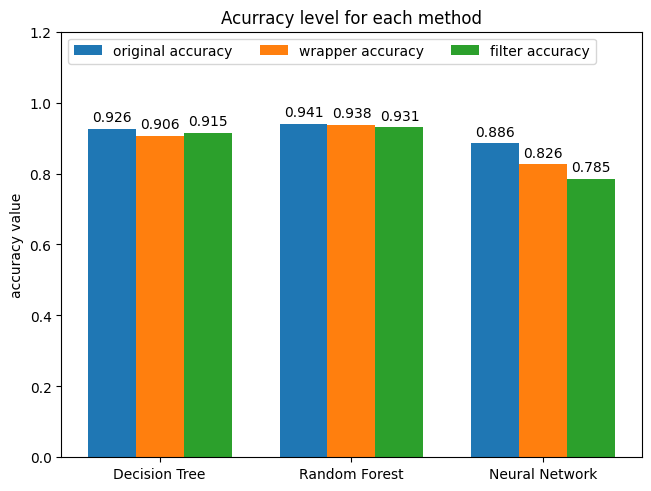

In [212]:
categories = ["Decision Tree", "Random Forest", "Neural Network"]
    
x = np.arange(len(categories))
width= 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')


for attribute, measurement in accuracy_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel("accuracy value")
ax.set_title('Acurracy level for each method')
ax.set_xticks(x + width, categories)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)

plt.show()